In [2]:
# 多条曲线：用于查看在特定计算场景下，mu和theta的变化对实际和估计的最优n*的影响

import pickle
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as random
from tqdm import tqdm

In [3]:
# computation scenario
B = 1
# input shape
C_i, H_i, W_i = 64, 224, 224
# output shape
C_o, H_o, W_o = 64, 224, 224

kernel_size, stride, padding = 3, 1, 1

conv_params = (B, C_i, H_i, W_i, C_o, H_o, W_o, kernel_size, stride, padding)

scale = 100000  # shape (scale, n) for generating random variables, n values per group


# rate parameter and shift parameter, should be set with proper values
#  master
mu_m, theta_m = 1e10, 1e-10
# #  worker: 4 CPU cores, 1.5 GHz = 1.5 * 10^9 Hz, maximum 10 MB/s
# #  - mu for computation: floating point operation per second
# #  - theta for computation: seconds per floating point operation
# #  - mu for transmission: bytes per second (B/s)
# #  - theta for computation: seconds per byte (s/B)

# tr parameters
# mus_tr = [1e5, 1e8, 1e7]
# thetas_tr = [1e-5, 1e-8, 1e-9]
mus_tr = [1e5, 1e6, 1e7]
thetas_tr = [1e-5, 1e-7, 1e-9]
# mu_theta_tr_pairs = [(mus_tr[0], thetas_tr[1]), (mus_tr[2], thetas_tr[1]), (mus_tr[1], thetas_tr[1]), (mus_tr[1], thetas_tr[0]), (mus_tr[1], thetas_tr[2])]
# mu_theta_tr_pairs_str = [('10^5', '10^{-8}'), ('10^7', '10^{-8}'), ('10^6', '10^{-8}'), ('10^6', '10^{-6}'), ('10^6', '10^{-10}')]
mu_theta_tr_pairs = [(mus_tr[0], thetas_tr[1]), (mus_tr[1], thetas_tr[0]), (mus_tr[1], thetas_tr[1]), (mus_tr[1], thetas_tr[2]), (mus_tr[2], thetas_tr[1])]
mu_theta_tr_pairs_str = [('10^5', '10^{-8}'), ('10^6', '10^{-6}'), ('10^6', '10^{-8}'), ('10^6', '10^{-10}'), ('10^7', '10^{-8}')]

# mu_theta_tr_pairs = mu_theta_tr_pairs
# mu_theta_tr_pairs_str = mu_theta_tr_pairs_str

# cmp parameters
mus_cmp = [1e7, 1e8, 1e9]
thetas_cmp = [1e-7, 1e-8, 1e-9]
# mu_theta_cmp_pairs = [(mus_cmp[0], thetas_cmp[1]), (mus_cmp[2], thetas_cmp[1]), (mus_cmp[1], thetas_cmp[1]), (mus_cmp[1], thetas_cmp[0]), (mus_cmp[1], thetas_cmp[2])]
# mu_theta_cmp_pairs_str = [('10^7', '10^{-8}'), ('10^9', '10^{-8}'), ('10^8', '10^{-8}'), ('10^8', '10^{-7}'), ('10^8', '10^{-9}')]
mu_theta_cmp_pairs = [(mus_cmp[0], thetas_cmp[1]), (mus_cmp[1], thetas_cmp[0]), (mus_cmp[1], thetas_cmp[1]), (mus_cmp[1], thetas_cmp[2]), (mus_cmp[2], thetas_cmp[1])]
mu_theta_cmp_pairs_str = [('10^7', '10^{-8}'), ('10^8', '10^{-7}'), ('10^8', '10^{-8}'), ('10^8', '10^{-9}'), ('10^9', '10^{-8}')]

mu_tr = mus_tr[1]
theta_tr = thetas_tr[1]
mu_cmp = 1e9
theta_cmp = 1e-8

In [4]:
# mu_m, theta_m = 1e10, 1e-10
mu_m, theta_m = 5e9, 5e-9

mus_tr = [1e7, 1e8, 1e9]  # 传输参数的初始值
thetas_tr = [1e-7, 1e-8, 1e-9]
mus_cmp = [1e7, 1e8, 1e9]
thetas_cmp = [1e-7, 1e-8, 1e-9]

mu_tr = mus_tr[1]
theta_tr = thetas_tr[1]
mu_cmp = mus_cmp[-1]
theta_cmp = thetas_cmp[-1]

generate_data = True
actual = True

In [5]:
from scipy.optimize import minimize, Bounds

def estimated_latency_n(system_params, conv_params, n, k):  # 估计时延的式子，应该和最后问题后包含近似的式子完全一致
    B, C_i, H_i, W_i, C_o, H_o, W_o, kernel_size, stride, padding = conv_params
    mu0_rec, theta0_rec, mu_cmp, theta_cmp, mu0_sen, theta0_sen = system_params
    
    mu_rec = mu0_rec / n
    mu_sen = mu0_sen / n
    theta_rec = theta0_rec * n
    theta_sen = theta0_sen * n

    Tm = (2*C_i*H_i*(kernel_size+(W_o/k-1)*stride)*k*n + 2*C_o*H_o*W_o*k)*(1/mu_m + theta_m)
    Ti_theta = 4*C_i*H_i*(kernel_size+(W_o/k-1)*stride)*theta_rec + 4*C_o*H_o*W_o/k*theta_sen + 2*C_o*H_o*W_o*C_i*(kernel_size**2)*theta_cmp/k
    Ti_mu = (4*C_i*H_i*(kernel_size+(W_o/k-1)*stride)/mu_rec + 4*C_o*H_o*W_o/(k*mu_sen) + 2*C_o*H_o*W_o*C_i*(kernel_size**2)/(k*mu_cmp)) * np.log(n/(n-k))
    # print(Tm, Ti_theta, Ti_mu)
    # result = ((2*k-1)*n*C_i*H_i*(kernel_size+(W_o/k-1)*stride) + (2*k-1)*C_o*H_o*W_o)*(1/mu_m + theta_m) \
    #     +4*C_i*H_i*(kernel_size+(W_o/k-1)*stride)*theta_rec + 4*C_o*H_o*W_o/k*theta_sen + C_o*H_o*W_o/k*2*C_i*(kernel_size**2)*theta_cmp \
    #     +(4*C_i*H_i*(kernel_size+(W_o/k-1)*stride)/mu_rec + 4*C_o*H_o*W_o/(k*mu_sen) + C_o*H_o*W_o*2*C_i*(kernel_size**2)/(k*mu_cmp))*np.log(n/(n-k))

    return Tm + Ti_theta + Ti_mu

def estimated_latency_n_1(system_params, conv_params, n, k):
    B, C_i, H_i, W_i, C_o, H_o, W_o, kernel_size, stride, padding = conv_params
    mu0_rec, theta0_rec, mu_cmp, theta_cmp, mu0_sen, theta0_sen = system_params

    Iov = np.prod([C_i, H_i, kernel_size - stride])
    IW = np.prod([C_i, H_i, W_o, stride])
    O = np.prod([C_o, H_o, W_o])
    Nc = np.prod([2.0, C_o, H_o, C_i, kernel_size, kernel_size, W_o]) # 这个用int32表示会溢出了
    # print(Iov, IW, O, Nc)  # 这里暂时没bug了

    h_1 = np.prod([2,Iov,1/mu_m+theta_m])
    h_2 = np.prod([2,IW,1/mu_m+theta_m])+np.prod([4,Iov,theta0_rec])
    h_3 = np.prod([2,O,1/mu_m+theta_m])
    h_4 = np.prod([4,IW,theta0_rec])+np.prod([4,O,theta0_sen])
    h_5 = np.prod([Nc,theta_cmp])
    h_6 = np.prod([4,Iov,1/mu0_rec])
    h_7 = np.prod([4,IW,1/mu0_rec])+np.prod([4,O,1/mu0_sen])
    h_8 = np.prod([Nc,1/mu_cmp])

    # L = np.prod([h_1,k,n])+np.prod([h_2,n]+np.prod([h_3,k]))+np.prod([h_4,n/k])+np.prod([h_5,1/])
    Lnk = h_1*k*n + h_2*n + h_3*k + h_4*n/k + h_5/k + h_6*n*np.log(n/(n-k)) + h_7*n/k*np.log(n/(n-k)) + h_8/k*np.log(n/(n-k))
    return Lnk

def estimated_derivative_n(system_params, conv_params, n, k):
    B, C_i, H_i, W_i, C_o, H_o, W_o, kernel_size, stride, padding = conv_params
    mu0_rec, theta0_rec, mu_cmp, theta_cmp, mu0_sen, theta0_sen = system_params

    Iov = np.prod([C_i, H_i, kernel_size - stride])
    IW = np.prod([C_i, H_i, W_o, stride])
    O = np.prod([C_o, H_o, W_o])
    Nc = np.prod([2.0, C_o, H_o, C_i, kernel_size, kernel_size, W_o])

    h_1 = np.prod([2, Iov, 1/mu_m+theta_m])
    h_2 = np.prod([2,IW,1/mu_m+theta_m])+np.prod([4,Iov,theta0_rec])
    h_3 = np.prod([2,O,1/mu_m+theta_m])
    h_4 = np.prod([4,IW,theta0_rec])+np.prod([4,O,theta0_sen])
    h_5 = np.prod([Nc,theta_cmp])
    h_6 = np.prod([4,Iov,1/mu0_rec])
    h_7 = np.prod([4,IW,1/mu0_rec])+np.prod([4,O,1/mu0_sen])
    h_8 = np.prod([Nc,1/mu_cmp])

    dn = h_1 * k + h_2 + h_4 / k + (h_6 + h_7/k)*(np.log(n/(n-k)) - k/(n-k)) - h_8/(n*(n-k))
    return dn

def objective_function(x, *args):
    n, k = x
    h1, h2, h3, h4, h5, h6, h7, h8 = args
    return h1 * k * n + h2 * n + h3 * k + h4 * n / k + h5 / k + h6 * n / np.log(n / (n - k)) + h7 * n / k * np.log(n / (n - k)) + h8 / k * np.log(n / (n - k))

def solve_nk_scipy(system_params, conv_params, n=None, k=None):
    if n is not None and k is not None:
        raise Exception('n and k cannot be both specified!')
    nk_cons = None
    if n is not None:
        nk_cons = {'type': 'eq', 'fun': lambda x: x[0] - n}
    if k is not None:
        nk_cons = {'type': 'eq', 'fun': lambda x: x[1] - k}
    B, C_i, H_i, W_i, C_o, H_o, W_o, kernel_size, stride, padding = conv_params
    mu0_rec, theta0_rec, mu_cmp, theta_cmp, mu0_sen, theta0_sen = system_params

    Iov = np.prod([C_i, H_i, kernel_size - stride])
    IW = np.prod([C_i, H_i, W_o, stride])
    O = np.prod([C_o, H_o, W_o])
    Nc = np.prod([2.0, C_o, H_o, C_i, kernel_size, kernel_size, W_o]) # 这个用int32表示会溢出了
    # print(Iov, IW, O, Nc)  # 这里暂时没bug了

    h_1 = np.prod([2.0,Iov,1/mu_m+theta_m])
    h_2 = np.prod([2.0,IW,1/mu_m+theta_m])+np.prod([4,Iov,theta0_rec])
    h_3 = np.prod([2,O,1/mu_m+theta_m])
    h_4 = np.prod([4,IW,theta0_rec])+np.prod([4,O,theta0_sen])
    h_5 = np.prod([Nc,theta_cmp])
    h_6 = np.prod([4,Iov,1/mu0_rec])
    h_7 = np.prod([4,IW,1/mu0_rec])+np.prod([4,O,1/mu0_sen])
    h_8 = np.prod([Nc,1/mu_cmp])

    constraints = [{'type': 'ineq', 'fun': lambda x: x[0] - x[1]}] # n >= k
    if nk_cons is not None:
        constraints.append(nk_cons)
    bounds = Bounds([3, 2], [np.inf, np.inf])

    initial_guess = [3, 2]
    result = minimize(objective_function, initial_guess, args=(h_1, h_2, h_3, h_4, h_5, h_6, h_7, h_8), constraints=constraints, bounds=bounds)
    print(f'n*,k*={result.x}   T*={result.fun}')

    if not result.success:
        print(result.message)
    return (result.fun, *result.x)


In [1]:

def search_optimal_n(system_params, conv_params, k):
    '''
    对于给定的系统参数，卷积参数（计算场景参数）以及k，返回实际以及估计的最优n以及对应的时延
    '''
    assert len(system_params) == 6
    assert len(conv_params) == 10
    B, C_i, H_i, W_i, C_o, H_o, W_o, kernel_size, stride, padding = conv_params
    mu0_rec, theta0_rec, mu_cmp, theta_cmp, mu0_sen, theta0_sen = system_params

    n_range = range(k+1, 100)
    ETc_n_actual = []
    ETc_n_approx = []
    ETc_n_estimated = []
    for n in tqdm(n_range):
        mu_rec_n = mu0_rec / n
        mu_sen_n = mu0_sen / n
        theta_rec_n = theta0_rec * n
        theta_sen_n = theta0_sen * n
        
        Wpo = W_o / k
        Wpi = kernel_size + (Wpo - 1) * stride

        Nenc = np.prod([(2 * k - 1), n, B, C_i, H_i, Wpi])  # in FLOPs (floating point operations)
        Ndec = np.prod([(2 * k - 1), k, B, C_o, H_o, Wpo])  # in FLOPs
        Nconv = np.prod([B, C_o, H_o, Wpo, C_i, kernel_size ** 2]) \
                    + np.prod([B, C_o, H_o, Wpo, C_i * (kernel_size ** 2)])  # in FLOPs
        Nin = np.prod([B, C_i, H_i, Wpi, 4])  # in bytes
        Nout = np.prod([B, C_o, H_o, Wpo, 4])  # in bytes

        # print(Nenc+Ndec, Nconv, Nin, Nout)

        Tenc = (1 / mu_m + theta_m) * Nenc
        Tdec = (1 / mu_m + theta_m) * Ndec
        Tm = Tenc + Tdec

        _murec = Nin / mu_rec_n
        _mucmp = Nconv / mu_cmp
        _musen = Nout / mu_sen_n

        Ts_rec = random.exponential(_murec, (scale, n))
        Ts_cmp = random.exponential(_mucmp, (scale, n))
        Ts_sen = random.exponential(_musen, (scale, n))

        Ts_w = Ts_rec + Ts_cmp + Ts_sen
        sum_offset = Nin * theta_rec_n + Nconv * theta_cmp + Nout * theta_sen_n
        
        # kth order statistic of Ts_w, Ts_rec, Ts_cmp, Ts_sen (合起来求o.s.)
        kth_Ts_w = np.partition(Ts_w, k - 1, axis=1)[:, k - 1]
        E_kth_Ts_w = np.mean(kth_Ts_w) + sum_offset + Tm
        ETc_n_actual.append((E_kth_Ts_w, n))

        # 分开求order statistic
        kth_Ts_rec = np.partition(Ts_rec, k - 1, axis=1)[:, k - 1]
        kth_Ts_cmp = np.partition(Ts_cmp, k - 1, axis=1)[:, k - 1]
        kth_Ts_sen = np.partition(Ts_sen, k - 1, axis=1)[:, k - 1]

        # estimation
        sum_kth_Ts = kth_Ts_rec + kth_Ts_cmp + kth_Ts_sen
        E_sum_kth = np.mean(sum_kth_Ts) + sum_offset + Tm
        ETc_n_approx.append((E_sum_kth, n))
        
        ETc_n_estimated.append((estimated_latency_n_1(system_params, conv_params, n, k), n))

        if n > k + 2:
            actual_larger = ETc_n_actual[-1][0] > ETc_n_actual[-2][0]
            approx_larger = ETc_n_approx[-1][0] > ETc_n_approx[-2][0]
            estimated_larger = ETc_n_estimated[-1][0] > ETc_n_estimated[-2][0]
            if actual_larger and approx_larger and estimated_larger:
                break
    
    ETc_n_actual.sort(key=lambda x: x[0])
    ETc_n_approx.sort(key=lambda x: x[0])
    ETc_n_estimated.sort(key=lambda x: x[0])

    return ETc_n_actual[0], ETc_n_approx[0], ETc_n_estimated[0]
    

# $\mu^{tr}_0$

In [6]:
# test impact of mu0_tr simulation and estimation

mus_tr = [1e8,2e8,3e8,4e8,5e8,6e8,7e8,8e8,9e8,1e9]  # 传输参数的初始值
xticks = '1e8,2e8,3e8,4e8,5e8,6e8,7e8,8e8,9e8,1e9'.split(',')
# mus_tr = [1e7,1e8,1e9]
thetas_tr = [1e-9,1e-8,1e-7]
mus_cmp = [5e7,1e8,2e8]
thetas_cmp = [1e-9,1e-8,1e-7]

# theta0_tr = theta_tr
theta0_tr = 1e-9
mus_tr_results = []
for mu0_tr in mus_tr:
    system_params = (mu0_tr, theta0_tr, mu_cmp, theta_cmp, mu0_tr, theta0_tr)
    # print(system_params)
    results = search_optimal_n(system_params, conv_params, 10)
    print('Results:',results)
    actual_n = results[0][-1]
    estimated_n = results[2][-1]
    k_range = range(min(actual_n, estimated_n), max(actual_n, estimated_n)+1)
    print(k_range)
    # derivates = [estimated_derivative_n(system_params, conv_params, n, 10) for n in k_range]
    # print(derivates)
    mus_tr_results.append(results)

  0%|          | 0/89 [00:00<?, ?it/s]

  9%|▉         | 8/89 [00:00<00:09,  8.40it/s]


Results: ((2.0798487366807126, 14), (2.019694783700707, 17), (2.0987645465872626, 18))
range(14, 19)


  8%|▊         | 7/89 [00:00<00:09,  8.60it/s]


Results: ((1.8512925128098625, 14), (1.8266217319502809, 17), (1.8986290165278632, 17))
range(14, 18)


  8%|▊         | 7/89 [00:00<00:09,  8.42it/s]


Results: ((1.7757514369728922, 15), (1.7606931319941017, 16), (1.8311601284147243, 17))
range(15, 18)


  7%|▋         | 6/89 [00:00<00:09,  8.42it/s]


Results: ((1.7362223487468686, 15), (1.7269751964379625, 16), (1.797048453289332, 16))
range(15, 17)


  7%|▋         | 6/89 [00:00<00:09,  8.84it/s]


Results: ((1.7140120276241253, 15), (1.70757178623668, 16), (1.7759904478361788, 16))
range(15, 17)


  7%|▋         | 6/89 [00:00<00:09,  8.70it/s]


Results: ((1.6989287968840392, 15), (1.6941539715492278, 16), (1.7619517775340765, 16))
range(15, 17)


  7%|▋         | 6/89 [00:00<00:09,  8.66it/s]


Results: ((1.6892167337887385, 15), (1.6847233894866076, 16), (1.7519241558897178, 16))
range(15, 17)


  7%|▋         | 6/89 [00:00<00:09,  8.81it/s]


Results: ((1.6813174755896936, 15), (1.6777134509086713, 16), (1.7444034396564487, 16))
range(15, 17)


  7%|▋         | 6/89 [00:00<00:09,  8.63it/s]


Results: ((1.6760051131404277, 15), (1.6718359969246113, 16), (1.7385539936972396, 16))
range(15, 17)


  7%|▋         | 6/89 [00:00<00:09,  8.57it/s]

Results: ((1.6704587495471164, 15), (1.6672687467617573, 16), (1.733874436929872, 16))
range(15, 17)


In [7]:
estimated_Tnk = []
for mu0_tr in mus_tr:
    system_params = (mu0_tr, theta0_tr, mu_cmp, theta_cmp, mu0_tr, theta0_tr)
    mus_tr_Tnk = solve_nk_scipy(system_params, conv_params, k=10)
    estimated_Tnk.append(mus_tr_Tnk)
    print(mus_tr_Tnk)

n*,k*=[10. 10.]   T*=21.675762555067863
Singular matrix E in LSQ subproblem
(21.675762555067863, 10.000000000000055, 10.0)
n*,k*=[16.67316405 10.        ]   T*=1.9005185826957358
(1.9005185826957358, 16.673164048281382, 10.0)
n*,k*=[10. 10.]   T*=16.168934290721875
Singular matrix E in LSQ subproblem
(16.168934290721875, 10.000000000000043, 10.0)
n*,k*=[16.31693721 10.        ]   T*=1.796730758211817
(1.796730758211817, 16.316937206953472, 10.0)
n*,k*=[16.24356754 10.        ]   T*=1.7758377783797605
(1.7758377783797605, 16.24356754339756, 10.0)
n*,k*=[10. 10.]   T*=15.113472804374979
Singular matrix E in LSQ subproblem
(15.113472804374979, 10.000000000000018, 10.0)
n*,k*=[10. 10.]   T*=14.30324192595829
Singular matrix E in LSQ subproblem
(14.30324192595829, 10.000000000000078, 10.0)
n*,k*=[10. 10.]   T*=14.269883272885561
Singular matrix E in LSQ subproblem
(14.269883272885561, 10.000000000000059, 10.0)
n*,k*=[16.11737215 10.        ]   T*=1.7385697297162905
(1.7385697297162905, 16.1

C:\Users\SUST\AppData\Local\Temp\ipykernel_12344\128738433.py:69: RuntimeWarning: invalid value encountered in log
  return h1 * k * n + h2 * n + h3 * k + h4 * n / k + h5 / k + h6 * n / np.log(n / (n - k)) + h7 * n / k * np.log(n / (n - k)) + h8 / k * np.log(n / (n - k))


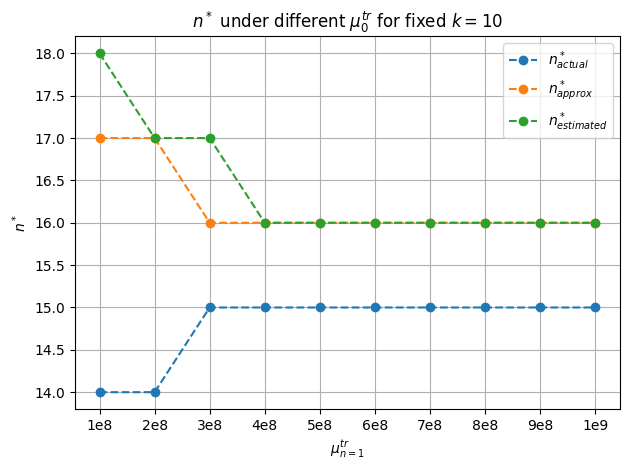

In [9]:
# draw impact of mu0_tr
optimal_ns_actual = [actual[1] for actual, _, _ in mus_tr_results]
# optimal_ks_actual = [actual[2] for actual, _, _ in mus_tr_results]
optimal_ns_approx = [approx[1] for _, approx, _ in mus_tr_results]
optimal_ns_estimated = [estimated[1] for _, _, estimated in mus_tr_results]
plt.figure()
plt.grid()
plt.title(r'$n^*$ under different $\mu^{tr}_{0}$ for fixed $k=10$')
plt.plot(optimal_ns_actual, 'o--', label='$n^*_{actual}$')
# plt.plot(optimal_ks_actual, 'x--', label='$k^*_{actual}$')
plt.plot(optimal_ns_approx, 'o--', label='$n^*_{approx}$')
# plt.plot(optimal_ks_estimated, 'x--', label='$k^*_{approx}$')
plt.plot(optimal_ns_estimated, 'o--', label='$n^*_{estimated}$')
plt.xticks(np.arange(len(mus_tr)), labels=xticks)
plt.xlabel('$\mu^{tr}_{n=1}$')
plt.ylabel('$n^*$')
plt.legend()
plt.tight_layout()
plt.show()

# $\theta^{tr}_0$

In [123]:
# test impact of theta0_tr
# theta^tr increases, n* increases
mus_tr = [1e6,1e7,1e8]  # 传输参数的初始值
thetas_tr = [1e-9,1e-8,1e-7] # theta increases
# thetas_tr = [1e-9,9e-8,8e-8,7e-8,6e-8,5e-8,4e-8,3e-8,2e-8,1e-8]
mus_cmp = [1e7,1e8,1e9]
thetas_cmp = [1e-9,1e-8,1e-7]

mu0_tr = mu_tr
thetas_tr_results = []
for theta0_tr in thetas_tr:
    system_params = (mu0_tr, theta0_tr, mu_cmp, theta_cmp, mu0_tr, theta0_tr)
    print(system_params)
    results = search_optimal_n(system_params, conv_params, 8)
    print(results)
    thetas_tr_results.append(results)

(100000000.0, 1e-09, 1000000000.0, 1e-09, 100000000.0, 1e-09)


  9%|▉         | 8/91 [00:00<00:08,  9.54it/s]


((2.0784890745162485, 12), (1.9624524131927683, 16), (2.058345806238585, 15))
(100000000.0, 1e-08, 1000000000.0, 1e-09, 100000000.0, 1e-08)


  5%|▌         | 5/91 [00:00<00:08, 10.18it/s]


((2.4178867437290226, 11), (2.3830219830090114, 13), (2.4834925557940832, 13))
(100000000.0, 1e-07, 1000000000.0, 1e-09, 100000000.0, 1e-07)


  2%|▏         | 2/91 [00:00<00:09,  9.71it/s]


((5.2056081799657345, 9), (5.400929942885888, 9), (5.681576233835562, 10))


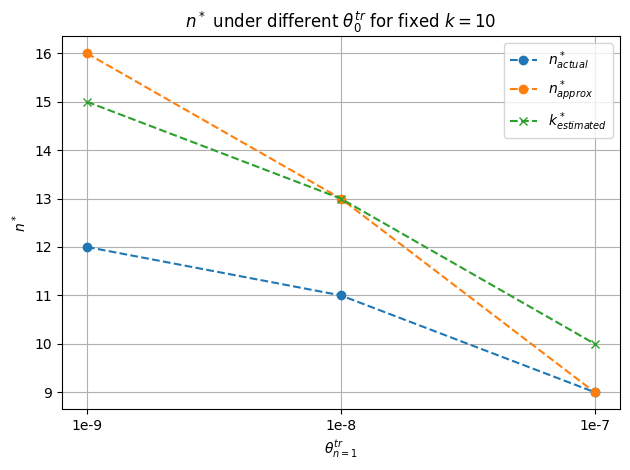

In [124]:
# draw impact of theta0_tr
optimal_ns_actual = [actual[1] for actual, _, _ in thetas_tr_results]
# optimal_ks_actual = [actual[2] for actual, _, _ in mus_tr_results]
optimal_ns_approx = [approx[1] for _, approx, _ in thetas_tr_results]
optimal_ks_estimated = [estimated[1] for _, _, estimated in thetas_tr_results]
plt.figure()
plt.grid()
plt.title(r'$n^*$ under different $\theta^{tr}_{0}$ for fixed $k=10$')
plt.plot(optimal_ns_actual, 'o--', label='$n^*_{actual}$')
# plt.plot(optimal_ks_actual, 'x--', label='$k^*_{actual}$')
plt.plot(optimal_ns_approx, 'o--', label='$n^*_{approx}$')
plt.plot(optimal_ks_estimated, 'x--', label='$k^*_{estimated}$')
plt.xticks(np.arange(len(thetas_tr)), labels='1e-9,1e-8,1e-7'.split(','))
plt.xlabel(r'$\theta^{tr}_{n=1}$')
plt.ylabel('$n^*$')
plt.legend()
plt.tight_layout()
plt.show()

# $\mu^{cmp}$

In [125]:
# test impact of mu_cmp
# mu^cmp increases, n* increases
mus_tr = [1e7,1e8,1e9]  # 传输参数的初始值
thetas_tr = [1e-9,1e-8,1e-7]
mus_cmp = [5e8,1e9,2e9]
thetas_cmp = [1e-9,1e-8,1e-7]

mu0_tr = mu_tr
theta0_tr = theta_tr
mu_cmp_results = []
for mu_cmp_i in mus_cmp:
    system_params = (mu0_tr, theta0_tr, mu_cmp_i, theta_cmp, mu0_tr, theta0_tr)
    print(system_params)
    results = search_optimal_n(system_params, conv_params, 10)
    print(results)
    mu_cmp_results.append(results)

(100000000.0, 1e-08, 500000000.0, 1e-09, 100000000.0, 1e-08)


  9%|▉         | 8/89 [00:00<00:09,  8.23it/s]


((2.822502091374412, 15), (2.7428854796629025, 18), (2.8422336787213567, 18))
(100000000.0, 1e-08, 1000000000.0, 1e-09, 100000000.0, 1e-08)


  6%|▌         | 5/89 [00:00<00:09,  8.40it/s]


((2.399738194813494, 13), (2.406626787387083, 15), (2.497578578833033, 15))
(100000000.0, 1e-08, 2000000000.0, 1e-09, 100000000.0, 1e-08)


  4%|▍         | 4/89 [00:00<00:09,  8.79it/s]

((2.1392474683900065, 12), (2.20246749428213, 14), (2.2840429179974553, 14))


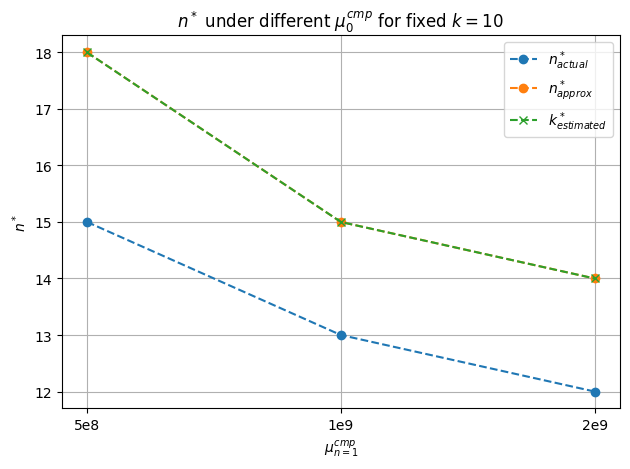

In [126]:
# draw impact of mu^cmp
optimal_ns_actual = [actual[1] for actual, _, _ in mu_cmp_results]
# optimal_ks_actual = [actual[2] for actual, _, _ in mus_tr_results]
optimal_ns_approx = [approx[1] for _, approx, _ in mu_cmp_results]
optimal_ks_estimated = [estimated[1] for _, _, estimated in mu_cmp_results]
plt.figure()
plt.grid()
plt.title(r'$n^*$ under different $\mu^{cmp}_{0}$ for fixed $k=10$')
plt.plot(optimal_ns_actual, 'o--', label='$n^*_{actual}$')
# plt.plot(optimal_ks_actual, 'x--', label='$k^*_{actual}$')
plt.plot(optimal_ns_approx, 'o--', label='$n^*_{approx}$')
plt.plot(optimal_ks_estimated, 'x--', label='$k^*_{estimated}$')
plt.xticks(np.arange(len(thetas_tr)), labels='5e8,1e9,2e9'.split(','))
plt.xlabel(r'$\mu^{cmp}_{n=1}$')
plt.ylabel('$n^*$')
plt.legend()
plt.tight_layout()
plt.show()

# $\theta^{cmp}$

In [12]:
# test impact of theta_cmp
# 确实不会影响n*的决策，只会影响时延（actual or real）
mus_tr = [1e6,1e7,1e8]  # 传输参数的初始值
thetas_tr = [1e-9,1e-8,1e-7]
mus_cmp = [1e7,1e8,1e9]
thetas_cmp = [1e-9,1e-8,1e-7]

mu0_tr = mu_tr
theta0_tr = theta_tr
theta_cmp_results = []
for theta_cmp_i in thetas_cmp:
    system_params = (mu0_tr, theta0_tr, mu_cmp, theta_cmp_i, mu0_tr, theta0_tr)
    print(system_params)
    results = search_optimal_n(system_params, conv_params, 8)
    print(results)
    theta_cmp_results.append(results)

(100000000.0, 1e-08, 1000000000.0, 1e-09, 100000000.0, 1e-08)


  5%|▌         | 5/91 [00:00<00:04, 21.10it/s]


((2.4183832844663478, 11), (2.3845663290645778, 13), (2.5122186816096814, 13))
(100000000.0, 1e-08, 1000000000.0, 1e-08, 100000000.0, 1e-08)


  5%|▌         | 5/91 [00:00<00:04, 20.08it/s]


((6.580331086426103, 11), (6.545769745213468, 13), (6.674016825609682, 13))
(100000000.0, 1e-08, 1000000000.0, 1e-07, 100000000.0, 1e-08)


  5%|▌         | 5/91 [00:00<00:04, 21.01it/s]

((48.19793833893464, 11), (48.164240190488165, 13), (48.29199826560968, 13))


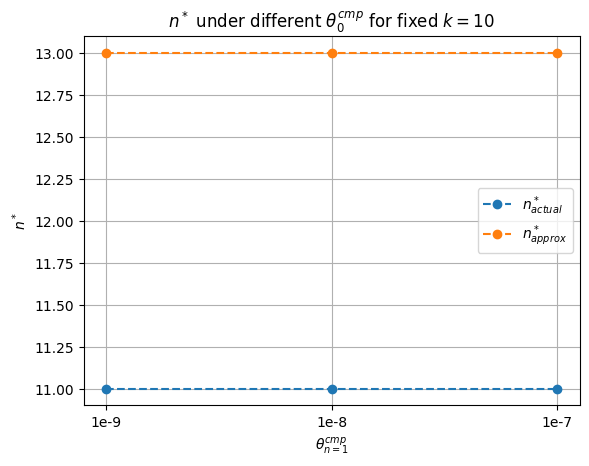

In [30]:
# draw impact of theta_cmp
optimal_ns_actual = [actual[1] for actual, _, _ in theta_cmp_results]
# optimal_ks_actual = [actual[2] for actual, _, _ in mus_tr_results]
optimal_ns_estimated = [estimated[1] for _, estimated, _ in theta_cmp_results]
# optimal_ks_estimated = [estimated[2] for _, estimated in mus_tr_results]
plt.figure()
plt.grid()
plt.title(r'$n^*$ under different $\theta^{cmp}_{0}$ for fixed $k=10$')
plt.plot(optimal_ns_actual, 'o--', label='$n^*_{actual}$')
# plt.plot(optimal_ks_actual, 'x--', label='$k^*_{actual}$')
plt.plot(optimal_ns_estimated, 'o--', label='$n^*_{approx}$')
# plt.plot(optimal_ks_estimated, 'x--', label='$k^*_{approx}$')
plt.xticks(np.arange(len(thetas_tr)), labels='1e-9,1e-8,1e-7'.split(','))
plt.xlabel(r'$\theta^{cmp}_{n=1}$')
plt.ylabel('$n^*$')
plt.legend()
plt.tight_layout()
plt.show()